# Analysis of: hazardst_stress.sql
#### File originally retrieved from: http://http://www.bitleak.net/Thread-Hazard-Stresser-Database-Dump

<h2 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
FIRST PART: Pre-Analysis<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h3> 

## 1.1. Declaring the database dump file location 

In [1]:
dumpfile='hazardst_stress.sql'

## 1.2. Taking a look on the raw dump file (first 100 lines)

In [2]:
lines_to_read=100

with open(dumpfile) as myfile:
    firstlines=myfile.readlines()[0:lines_to_read] #put here the interval you want
    for x in firstlines:
        print(x.strip())

-- phpMyAdmin SQL Dump
-- version 3.5.5
-- http://www.phpmyadmin.net
--
-- Host: localhost
-- Generation Time: Apr 11, 2013 at 09:11 AM
-- Server version: 5.1.68-cll
-- PHP Version: 5.3.17

SET SQL_MODE="NO_AUTO_VALUE_ON_ZERO";
SET time_zone = "+00:00";


/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8 */;

--
-- Database: `hazardst_stress`
--

-- --------------------------------------------------------

--
-- Table structure for table `blacklist`
--

CREATE TABLE IF NOT EXISTS `blacklist` (
`ID` int(11) NOT NULL AUTO_INCREMENT,
`IP` varchar(15) NOT NULL,
`note` text NOT NULL,
PRIMARY KEY (`ID`)
) ENGINE=MyISAM  DEFAULT CHARSET=latin1 AUTO_INCREMENT=51 ;

--
-- Dumping data for table `blacklist`
--

INSERT INTO `blacklist` (`ID`, `IP`, `note`) VALUES
(41, '127.0.0.1', 'dont remove'),
(42, '127.0.0.1', 'Localhost'

<h2 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
SECOND PART: Adapt to Our Generic Database Schema<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h3> 

## 2.0. Used Libraries

In [3]:
import pandas as pd
import numpy as np

from io import StringIO
import re

from IPython.display import display,clear_output

## 2.1. Listing tables that have content inserted into the dump file

In [4]:
def list_tables_with_insert(dumpfile):
    tables = []
    with open(dumpfile, 'rb') as f:
        for line in f:
            line = line.decode("utf-8").strip()
            if line.lower().startswith('insert'):
                table = re.findall(r'`(.*?)`', line)
                tables.append(table[0])
    return tables

In [5]:
tables=enumerate(list_tables_with_insert(dumpfile))

for i, item in tables:
    print(i+1,item)

1 blacklist
2 fe
3 gateway
4 iplogs
5 logs
6 lr
7 news
8 payments
9 plans
10 servers
11 settings
12 sitelink
13 sitetheme
14 skypeapi
15 skype_logs
16 users


## 2.2. Read tables, one by one, and perform required adaptations 

In [6]:
def read_inserted_table(dumpfile, target_table):
    sio = StringIO()
    fast_forward = True
    with open(dumpfile, 'rb') as f:
        for line in f:
            line = line.decode("utf-8").strip()
            line = re.sub("(?!(([^']*'){2})*[^']*$)\)", '',line) #Step0:remove any ")" from the content of columns
            if line.lower().startswith('insert') and target_table in line:
                fast_forward = False
            if fast_forward:
                continue
            data = re.findall('\([^\)]*\)', line) #Step1: get the content between parentesis (i.e., insert line)
            try:
                newline = data[0].strip('()') #Step2:remove parenthesis
                newline=newline.replace('`','') #Step3: remove ` (usually in table names)
                newline=re.sub(r'(?!(([^\']*\'){2})*[^\']*$),', '', newline) #Step4: remove commas from the content of columns
                newline=newline.replace('\'','') #Step5: remove single quotes
                newline=newline.replace(', ', ',') #Step6: remove single spaces after comma (i.e., in the beginning of a column)
                sio.write(newline)
                sio.write("\n")
            except IndexError:
                pass
            if line.endswith(';'):
                break
    sio.seek(0)
    return sio

## 2.2.0. Converter functions

In [7]:
def tolowercase(text):
    try:
        return text.lower()
    except AttributeError:
        return text 

In [8]:
def timestamp2datetime(timestamp):
    try:
        return  pd.to_datetime(timestamp,unit='s')
    except AttributeError:
        return timestamp 

## 2.2.1. Read the raw table: 'blacklist'

In [9]:
tablename='blacklist'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,IP,note
0,41,127.0.0.1,dont remove
1,42,127.0.0.1,Localhost
2,43,141.101.121.10,Hack forums
3,47,72.21.81.85,FBI DO NOT REMOVE
4,48,198.81.129.107,CIA


#### Q1: Is this table different from other previous loaded table? YES
#### Q2: Is this table similar to any table in the generic Booter database schema? YES
    - This table looks like: blacklist
    - The blacklist table must to have the columns: id, ip, and note
#### Q3: Are there modifications required? YES
    - On the table name: NO
    - On the column type: NO
    - On the column name:
        o ID => id
        o IP => ip
    - Add required columns: NO

## 2.2.1.X Loading the modified table: 'blacklist'

In [10]:
df_blacklist = pd.read_csv(read_inserted_table(dumpfile, tablename),
                           delimiter=",",
                           error_bad_lines=False)

df_blacklist.rename(columns = {'ID': 'id',
                               'IP':'ip'},
                    inplace=True)
df_blacklist

,id,ip,note
0,41,127.0.0.1,dont remove
1,42,127.0.0.1,Localhost
2,43,141.101.121.10,Hack forums
3,47,72.21.81.85,FBI DO NOT REMOVE
4,48,198.81.129.107,CIA


## 2.2.2. Read the raw table: 'fe'

In [11]:
tablename='fe'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,userID,type,ip,note
0,6,50,e,74.197.70.58,DinosaurPhoneFaggot
1,40,55473,e,24.29.209.124,Rox Treats
2,8,55408,f,101.119.16.166,Brooke
3,9,55408,f,69.171.237.11,Lara
4,10,55473,e,173.168.120.50,tricks
5,11,55473,e,76.122.153.50,Nturl Blur
6,12,55473,e,68.47.220.26,Frost
7,13,55510,f,94.236.162.145,www.openmu.com
8,14,55475,e,108.13.167.70,NaN
9,15,55547,f,75.65.207.197,LANDON


### Observations compared to generic Booter database schema
    - This table looks like: friendsenemies
    - The friendsenemies table must to have the columns: id, note, userid, and type
### Modifications 
    - On the column name:
        + ID changes to id, 
        + userID changes to userid;

## 2.2.2.X Loading the modified table: 'fe'

In [12]:
df_friendsenemies = pd.read_csv(read_inserted_table(dumpfile, tablename),
                                delimiter=",",
                                error_bad_lines=False)

df_friendsenemies.rename(columns = {'ID': 'id',
                               'userID':'userid'},
                    inplace=True)

df_friendsenemies.head(10)

,id,userid,type,ip,note
0,6,50,e,74.197.70.58,DinosaurPhoneFaggot
1,40,55473,e,24.29.209.124,Rox Treats
2,8,55408,f,101.119.16.166,Brooke
3,9,55408,f,69.171.237.11,Lara
4,10,55473,e,173.168.120.50,tricks
5,11,55473,e,76.122.153.50,Nturl Blur
6,12,55473,e,68.47.220.26,Frost
7,13,55510,f,94.236.162.145,www.openmu.com
8,14,55475,e,108.13.167.70,NaN
9,15,55547,f,75.65.207.197,LANDON


## 2.2.3. Read the raw table: 'gateway'

In [13]:
tablename='gateway'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,email
0,misterp30@icloud.com


### Observations compared to generic Booter database schema
    - This table looks like: gateways
    - The gateways table must to have the columns: email
### Modifications 
    - On the table name: gateway becomes gateways.
    - On the column name: no modification requires.

## 2.2.3.X Loading the modified table: 'gateway'

In [14]:
df_gateways = pd.read_csv(read_inserted_table(dumpfile, tablename),
                                delimiter=",",
                                error_bad_lines=False)

df_gateways.head(10)

,email
0,misterp30@icloud.com


## 2.2.4. Read the raw table: 'iplogs'

In [15]:
tablename='iplogs'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,userID,logged,date
0,16,55388,77.126.24.144,1354474645
1,17,55388,77.126.24.144,1354474652
2,18,55408,69.171.237.11,1354688757
3,19,55408,211.30.228.242,1354688757
4,20,55408,101.119.16.166,1354688821
5,21,55408,101.119.16.166,1354688942
6,22,55408,122.106.80.6,1354689641
7,23,55408,122.106.80.6,1354689651
8,24,55408,122.106.80.6,1354689671
9,25,55408,49.2.16.250,1354689897


*Is this table exactly the same as any other previous loaded table? NO
### Observations compared to generic Booter database schema
    - This table looks like: logins
    - The  table must to have the columns: id, userid, userip, and date
### Modifications 
    - On the table name: 
        o iplogs => logins
    - Convert column:
        o date => timestamp2datetime
    - On the column name: 
        o ID => id
        o userID => userid
        o logged => userip

## 2.2.4.X Loading the modified table: 'iplogs'

In [16]:
df_logins = pd.read_csv(read_inserted_table(dumpfile, tablename),
                                delimiter=",",
                                error_bad_lines=False,
                       converters = {'date':timestamp2datetime})

df_logins.rename(columns = {'ID': 'id',
                            'userID':'userid',
                            'logged': 'userip'},
                    inplace=True)

df_logins.head(10)

,id,userid,userip,date
0,16,55388,77.126.24.144,2012-12-02 18:57:25
1,17,55388,77.126.24.144,2012-12-02 18:57:32
2,18,55408,69.171.237.11,2012-12-05 06:25:57
3,19,55408,211.30.228.242,2012-12-05 06:25:57
4,20,55408,101.119.16.166,2012-12-05 06:27:01
5,21,55408,101.119.16.166,2012-12-05 06:29:02
6,22,55408,122.106.80.6,2012-12-05 06:40:41
7,23,55408,122.106.80.6,2012-12-05 06:40:51
8,24,55408,122.106.80.6,2012-12-05 06:41:11
9,25,55408,49.2.16.250,2012-12-05 06:44:57


## 2.2.5. Read the raw table: 'logs'

In [17]:
tablename='logs'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,userID,logged,date
0,16,55388,77.126.24.144,1354474645
1,17,55388,77.126.24.144,1354474652
2,18,55408,69.171.237.11,1354688757
3,19,55408,211.30.228.242,1354688757
4,20,55408,101.119.16.166,1354688821
5,21,55408,101.119.16.166,1354688942
6,22,55408,122.106.80.6,1354689641
7,23,55408,122.106.80.6,1354689651
8,24,55408,122.106.80.6,1354689671
9,25,55408,49.2.16.250,1354689897


### Is this table exactly the same as any other previous loaded table? YES (iplogs)
    * Do nothing!
### Is this table similar to any table in the generic Booter database schema? 
    - This table looks like: 
    - The  table must to have the columns: -
### Modifications 
    - On the table name: 
    - Convert column:
    - On the column name: 

## 2.2.6. Read the raw table: 'lr'

In [18]:
tablename='lr'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,storename,storepass,lrid
0,Sly Stresser,phoenix310,U7700723


### Is this table exactly the same as any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? NO
    - This table looks like: 
    - The  table must to have the columns: 
### Are there required adjustments? 
    - On the table name: 
    - On the column type:
    - On the column name: 

## 2.2.7. Read the raw table: 'news'

In [19]:
tablename='news'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,title,detail,date
0,22,ToS (Terms of Service,1. No refunds. 2. No chargebacks,1365648068


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? NO 
    - This table looks like: -
    - The  table must to have the columns: -
### Are there modifications required?
    - On the table name: 
    - On the column type:
    - On the column name: 

## 2.2.8. Read the raw table: 'payments'

In [20]:
tablename='payments'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,paid,plan,user,email,tid,date
0,1,2,25,55864,konradsenko@hotmail.com,730447104V3576257,1363038749
1,2,5,26,55860,michael120@live.nl,3M900294Y7261862G,1363042743
2,3,5,26,55875,crimewatchtt@gmail.com,2XR028731C564574Y,1363051326
3,4,5,26,55878,billing@hotservers.net,3JW09853GT390105Y,1363060180
4,5,20,27,55880,runescape0617@gmail.com,5WG75384XD256082W,1363065720
5,6,2,25,55882,PwNChocolaHD@gmail.com,11B593471U493523W,1363070417
6,7,2,25,55890,storm@ebomba.ro,2SG53730PR905211S,1363123642
7,8,30,33,55890,storm@ebomba.ro,27D205791C673071T,1363124779
8,9,5,26,55891,teflonjuan01@aol.com,4NP36572RX387190F,1363126981
9,10,12,28,55893,gl0zz3n@gmail.com,98J04628W32780214,1363137875


### Is this table completely different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? YES
    - This table looks like: payments
    - The  table must to have the columns: id, userid, amountpaid, useremail, planid, tid, and date
### Are there modifications required? YES
    - On the table name: NO
    - On the column type:
        o date => timestamp2datetime
    - On the column name: 
        o ID => id
        o paid => amountpaid
        o plan => planid
        o user => userid
        o email => paymentemail

## 2.2.8.X Loading the modified table: 'payments'

In [21]:
df_payments = pd.read_csv(read_inserted_table(dumpfile, tablename),
                                delimiter=",",
                                error_bad_lines=False,
                       converters = {'date':timestamp2datetime})

df_payments.rename(columns = {'ID': 'id',
                            'paid':'amountpaid',
                            'plan': 'planid',
                             'user': 'userid',
                             'email': 'paymentemail'},
                    inplace=True)

df_payments.head(10)

,id,amountpaid,planid,userid,paymentemail,tid,date
0,1,2,25,55864,konradsenko@hotmail.com,730447104V3576257,2013-03-11 21:52:29
1,2,5,26,55860,michael120@live.nl,3M900294Y7261862G,2013-03-11 22:59:03
2,3,5,26,55875,crimewatchtt@gmail.com,2XR028731C564574Y,2013-03-12 01:22:06
3,4,5,26,55878,billing@hotservers.net,3JW09853GT390105Y,2013-03-12 03:49:40
4,5,20,27,55880,runescape0617@gmail.com,5WG75384XD256082W,2013-03-12 05:22:00
5,6,2,25,55882,PwNChocolaHD@gmail.com,11B593471U493523W,2013-03-12 06:40:17
6,7,2,25,55890,storm@ebomba.ro,2SG53730PR905211S,2013-03-12 21:27:22
7,8,30,33,55890,storm@ebomba.ro,27D205791C673071T,2013-03-12 21:46:19
8,9,5,26,55891,teflonjuan01@aol.com,4NP36572RX387190F,2013-03-12 22:23:01
9,10,12,28,55893,gl0zz3n@gmail.com,98J04628W32780214,2013-03-13 01:24:35


## 2.2.9. Read the raw table: 'plans'

In [22]:
tablename='plans'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,name,description,mbt,unit,length,price
0,32,Lifetime - 1200 Seconds,Lifetime - 1200 Seconds,1200,Years,20,42.0
1,28,2 Month\\s - 600 Seconds,2 Month\\s - 600 Seconds,600,Months,2,12.0
2,30,Lifetime - 600 Seconds,Lifetime - 600 Seconds,600,Years,20,30.0
3,31,2 Month\\s - 1200 Seconds,2 Month\\s - 1200 Seconds,1200,Months,2,22.0
4,27,Lifetime - 300 Seconds,Lifetime - 300 Seconds,300,Years,20,20.0
5,25,300 Seconds - 1 Day,300 Seconds - 1 Day,300,Days,1,2.0
6,26,2 Month\\s - 300 Seconds,2 Month\\s - 300 Seconds,300,Months,2,5.0
7,33,2 Month\\s - 3600,2 Month\\s - 3600 Seconds,3600,Months,2,30.0
8,34,Lifetime - 3600 Seconds,Lifetime - 3600 Seconds,3600,Years,20,50.0
9,35,Contest Package ;,Do not buy this Package,4600,Years,10,10000000.0


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? YES
    - This table looks like: plans
    - The  table must to have the columns: planid, planname, plandescr, price, maxboottime, and concurrency
### Are there modifications required? YES
    - On the table name: NO
    - On the column type:
    - On the column name: 
        o ID => planid
        o name => planname
        o description => plandescr
        o mbt => maxboottime
        o length => concurrency

## 2.2.9.X Loading the modified table: 'plans'

In [23]:
df_plans = pd.read_csv(read_inserted_table(dumpfile, tablename),
                                delimiter=",",
                                error_bad_lines=False)

df_plans.rename(columns = {'ID': 'planid',
                            'name': 'planname',
                          'description': 'plandescr',
                          'mbt':'maxboottime',
                          'length':'concurrency'},
                    inplace=True)

df_plans.head(10)

,planid,planname,plandescr,maxboottime,unit,concurrency,price
0,32,Lifetime - 1200 Seconds,Lifetime - 1200 Seconds,1200,Years,20,42.0
1,28,2 Month\\s - 600 Seconds,2 Month\\s - 600 Seconds,600,Months,2,12.0
2,30,Lifetime - 600 Seconds,Lifetime - 600 Seconds,600,Years,20,30.0
3,31,2 Month\\s - 1200 Seconds,2 Month\\s - 1200 Seconds,1200,Months,2,22.0
4,27,Lifetime - 300 Seconds,Lifetime - 300 Seconds,300,Years,20,20.0
5,25,300 Seconds - 1 Day,300 Seconds - 1 Day,300,Days,1,2.0
6,26,2 Month\\s - 300 Seconds,2 Month\\s - 300 Seconds,300,Months,2,5.0
7,33,2 Month\\s - 3600,2 Month\\s - 3600 Seconds,3600,Months,2,30.0
8,34,Lifetime - 3600 Seconds,Lifetime - 3600 Seconds,3600,Years,20,50.0
9,35,Contest Package ;,Do not buy this Package,4600,Years,10,10000000.0


## 2.2.10. Read the raw table: 'servers'

In [24]:
tablename='servers'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,id,url
0,71,http://respawnapi.com/send.php?host=&port=&tim...
1,69,http://31.3.227.80/Koala/api.php?key=X8c6Hv06f...


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? YES
    - This table looks like: webshell
    - The  table must to have the columns: id, url, status, lastchecked, and attacktype
### Are there modifications required? YES
    - On the table name: 
        o servers => webshells
    - On the column type: -
    - On the column name: - 
    - Add required columns:
        o status, lastchecked, and attacktype

## 2.2.10.X Loading the modified table: 'servers'

In [25]:
df_webshells = pd.read_csv(read_inserted_table(dumpfile, tablename),
                                delimiter=",",
                                error_bad_lines=False)

df_webshells['status'] = np.nan
df_webshells['lastchecked'] = np.nan
df_webshells['attacktype'] = np.nan

df_webshells.head(10)

,id,url,status,lastchecked,attacktype
0,71,http://respawnapi.com/send.php?host=&port=&tim...,NaN,NaN,NaN
1,69,http://31.3.227.80/Koala/api.php?key=X8c6Hv06f...,NaN,NaN,NaN


## 2.2.11. Read the raw table: 'settings'

In [26]:
tablename='settings'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,name
0,Hazard Stresser


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? YES
    - This table looks like: settings
    - The  table must to have the columns: url, sitename, and siteemail
### Are there modifications required? YES
    - On the table name: -
    - On the column type: -
    - On the column name:
        o name => sitename
    - Add required columns:
        o url and siteemail

## 2.2.11.X Loading the modified table: 'settings'

In [27]:
df_settings = pd.read_csv(read_inserted_table(dumpfile, tablename),
                                delimiter=",",
                                error_bad_lines=False)
#                        converters = {'date':timestamp2datetime})

df_settings.rename(columns = {'name': 'sitename'},
                    inplace=True)

#Creating empty columns (with "" [for future string] or np.nan [for future float])
df_settings['url'] = ""
df_settings['siteemail'] = ""

df_settings.head(10)

,sitename,url,siteemail
0,Hazard Stresser,,


## 2.2.12. Read the raw table: 'sitelink'

In [28]:
tablename='sitelink'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,url
0,http://hazardstresser.com/


### Is this table different from any other previous loaded table? NO
    * It is part should be part of the settings table!!!
### Is this table similar to any table in the generic Booter database schema? 
    - This table looks like: 
    - The  table must to have the columns: 
### Are there modifications required? 
    - On the table name: 
    - On the column type:
    - On the column name:
    - Add required columns:


## 2.2.12.X Loading the modified table: 'sitelink'

In [29]:
## Moving the value of URL to the table settings!
df_settings.set_value(0,'url',
                      pd.read_csv(read_inserted_table(dumpfile, tablename))['url'].iloc[0])

,sitename,url,siteemail
0,Hazard Stresser,http://hazardstresser.com/,


## 2.2.13. Read the raw table: 'sitetheme'

In [30]:
tablename='sitetheme'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,theme
0,strangeblue


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? NO
    - This table looks like: 
    - The  table must to have the columns: 
### Are there modifications required? 
    - On the table name: 
    - On the column type:
    - On the column name:
    - Add required columns:

## 2.2.14. Read the raw table: 'skypeapi'

In [31]:
tablename='skypeapi'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,link
0,http://api.sonicb00m.com/api.php?key=koala&name=


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? NO
### Are there modifications required? 

## 2.2.15. Read the raw table: 'skype_logs'

In [32]:
tablename='skype_logs'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,user,ip,searched
0,gl0zz3n,Could not resolve skype username.,grimthegod
1,xbox12,Could not resolve skype username.,jacob campbell
2,xbox12,Could not resolve skype username.,jacob.campbell
3,xbox12,Could not resolve skype username.,jacob.campbell
4,xbox12,Could not resolve skype username.,jacob campbell
5,xbox12,72.222.142.254,googlemyweiner
6,xbox12,Could not resolve skype username.,austin.ozan
7,CorruptedTNC,65.33.98.82,blakesvengeance
8,baconback,80.192.255.210,joker16345
9,baconback,Could not resolve skype username.,mikeapaloosa


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? NO
### Are there modifications required? 

## 2.2.16. Read the raw table: 'users'

In [33]:
tablename='users'

pd.read_csv(read_inserted_table(dumpfile, tablename),
            delimiter=",",
            error_bad_lines=False).head(10)

,ID,username,password,email,rank,membership,expire,status
0,55945,xXEnvyUnknownXx,f865b53623b121fd34ee5426c792e5c33af8c227,course@live.com,0,34,1994563582,0
1,55944,Snooper,f4f5a044094964a68c9232041b117f7f9cebfbc5,froudrea@fakeinbox.com,0,26,1368671578,0
2,55943,cr3m3,a14b77b7d159a74da1454e7a60a59f8a27ac886d,cr3m3brul33@hotmail.com,0,28,1368667528,0
3,55942,JH450,bb4dd53303ea7bb0a6807a12f78ede4099782758,thebeast4564@aol.com,0,0,0,0
4,55941,aaronuk12,16732c08da90d4a96bdd249481411d4900e4b504,aaronuk12@hotmail.com,0,0,0,0
5,55940,Cr0NiX,25543c240eaccb98c28e57b67de518de53410da1,bonniedog96@gmail.com,0,25,1363467382,0
6,55939,n0mad315,93deb6737b2b5b9a1feaa82ef742cc6b52272bb7,idrees_d@hotmail.co.uk,0,34,1994519785,0
7,55938,Honeyz,c76b1da7fc4db39184bac03eaf1e31b113d25eb6,paixtouras2010@hotmail.com,0,0,0,0
8,55937,Dave,1ba00d2112e3c8f6ee5dc7eb5ed14d98764abf8a,team-escape@hotmail.com,0,0,0,0
9,55936,asdasd,85136c79cbf9fe36bb9d05d0639c70c265c18d37,asd@asd.com,0,0,0,0


### Is this table different from any other previous loaded table? YES
### Is this table similar to any table in the generic Booter database schema? YES
    - This table looks like: users
    - The  table must to have the columns: userid, username, useremail, password, expire, and plan
### Are there modifications required? 
    - On the table name: NO
    - On the column type: 
        o expire => timestamp2datetime
    - On the column name:
        o ID => userid
        o email => useremail
        o membership => planid
    - Add required columns: NO

## 2.2.16.X Loading the modified table: 'users'

In [34]:
df_users = pd.read_csv(read_inserted_table(dumpfile, tablename),
                       delimiter=",",
                       error_bad_lines=False,
                       converters = {'expire':timestamp2datetime,
                                    'username':tolowercase})

df_users.rename(columns = {'ID': 'userid',
                          'email':'useremail',
                          'membership':'planid'},
                    inplace=True)

##Create blank columns (with either "" [for string] or np.nan [for float])
# df_users['url'] = ""
# df_users['siteemail'] = np.nan

df_users.head(10)

,userid,username,password,useremail,rank,planid,expire,status
0,55945,xxenvyunknownxx,f865b53623b121fd34ee5426c792e5c33af8c227,course@live.com,0,34,2033-03-16 05:26:22,0
1,55944,snooper,f4f5a044094964a68c9232041b117f7f9cebfbc5,froudrea@fakeinbox.com,0,26,2013-05-16 02:32:58,0
2,55943,cr3m3,a14b77b7d159a74da1454e7a60a59f8a27ac886d,cr3m3brul33@hotmail.com,0,28,2013-05-16 01:25:28,0
3,55942,jh450,bb4dd53303ea7bb0a6807a12f78ede4099782758,thebeast4564@aol.com,0,0,1970-01-01 00:00:00,0
4,55941,aaronuk12,16732c08da90d4a96bdd249481411d4900e4b504,aaronuk12@hotmail.com,0,0,1970-01-01 00:00:00,0
5,55940,cr0nix,25543c240eaccb98c28e57b67de518de53410da1,bonniedog96@gmail.com,0,25,2013-03-16 20:56:22,0
6,55939,n0mad315,93deb6737b2b5b9a1feaa82ef742cc6b52272bb7,idrees_d@hotmail.co.uk,0,34,2033-03-15 17:16:25,0
7,55938,honeyz,c76b1da7fc4db39184bac03eaf1e31b113d25eb6,paixtouras2010@hotmail.com,0,0,1970-01-01 00:00:00,0
8,55937,dave,1ba00d2112e3c8f6ee5dc7eb5ed14d98764abf8a,team-escape@hotmail.com,0,0,1970-01-01 00:00:00,0
9,55936,asdasd,85136c79cbf9fe36bb9d05d0639c70c265c18d37,asd@asd.com,0,0,1970-01-01 00:00:00,0


## 3.1. Adding missing accordingly to our generic Booter database 

In [35]:
df_attacks= pd.DataFrame(columns=['id','userid','targeturl','targetip','duration','port','date'])
df_attacks

,id,userid,targeturl,targetip,duration,port,date


<h2 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
THIRD PART: Data Enrichment<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h3> 

## 3.0. Needed Libraries

In [36]:
import subprocess

import cfscrape
from lxml import etree

import os.path

import random
import time 

## 3.1. Lookup functions

In [37]:
# THANKS TO: team-cymru.org
def iptoasn(iplist_teamcymruformat_filelocation,outputfile):
    cat = subprocess.Popen(['cat', iplist_teamcymruformat_filelocation], 
                            stdout=subprocess.PIPE)
    
    netcat = subprocess.Popen(['netcat', 'whois.cymru.com', '43'],
                              stdin=cat.stdout,
                              stdout=outputfile)
    time.sleep(3) #for some reason the poll does not work! This was the way to overcome the waiting time.
    
    return netcat.stdout      

In [38]:
# THANKS TO: exonerator.torproject.org
def WasTorNode(ip, date ):
    url="https://exonerator.torproject.org/?ip="+ip+"&timestamp="+date
    scraper = cfscrape.create_scraper()
    scraped_html=scraper.get(url).content    
    html_tree = etree.HTML(scraped_html)
    result=html_tree.xpath("//h3[@class='panel-title']/text()") # I was looking for <h3 class="panel-title">Result is positive</h3>
    tor_node=True if result == ['Result is positive'] else False
    return tor_node 
# 'date' MUST BE formated as: Year-month-day (2016-03-31)

## 3.2. Discovering the middle date of the database

In [39]:
try:
    try:
        middle_date=(min(df_attacks['date'])+((max(df_attacks['date'])-min(df_attacks['date']))/2))
        raise
    except Exception:
        pass

    try:
        middle_date=(min(df_logins['date'])+((max(df_logins['date'])-min(df_logins['date']))/2))
        raise
    except Exception:
        pass

    try:
        middle_date=(min(df_payments['date'])+((max(df_payments['date'])-min(df_payments['date']))/2))
        raise
    except:
        pass
except Exception:
    print("There is no date in the entire dataset")

date_tor_check = middle_date.strftime('%Y-%m-%d')
date_iptoasn_lookup= str(middle_date)
print(date_tor_check)

2013-03-27


## 3.3 Preparing to Perform IP to ASN info

In [40]:
df_logins['middledate']=date_iptoasn_lookup
df_attacks['middledate']=date_iptoasn_lookup
df_friendsenemies['middledate']=date_iptoasn_lookup
df_blacklist['middledate']=date_iptoasn_lookup

## 3.4.1  Lookup IP to ASN info of table: logins

In [41]:
if (os.path.exists('logins_iptoasn_out')== False):
    logins_iptoasn_in = open('logins_iptoasn_in', 'w+')
    logins_iptoasn_in.write('begin\nverbose\n')
    df_logins[['userip','middledate']].drop_duplicates().to_csv(logins_iptoasn_in,header=False,index=False,sep="\t") 
    logins_iptoasn_in.write('end')
    logins_iptoasn_in.close()

    logins_iptoasn_out = open('logins_iptoasn_out', 'w+')
    iptoasn('logins_iptoasn_in',logins_iptoasn_out)
    logins_iptoasn_out.close()
else:
    print("You already performed the lookup for this table")

You already performed the lookup for this table


In [42]:
df_logins_iptoasn = pd.read_csv('logins_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_logins_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name
0,9116,77.126.24.144,77.126.16.0/20,IL,ripencc,2006-11-07,2013-03-27 00:19:24.500000,GOLDENLINES-ASN 012 Smile Communications Main ...
1,32934,69.171.237.11,69.171.224.0/20,US,arin,2010-08-05,2013-03-27 00:19:24.500000,"FACEBOOK - Facebook, Inc., US"
2,4804,211.30.228.242,211.30.224.0/19,AU,apnic,2003-07-01,2013-03-27 00:19:24.500000,"MPX-AS Microplex PTY LTD, AU"
3,133612,101.119.16.166,101.112.0.0/13,AU,apnic,2010-12-14,2013-03-27 00:19:24.500000,"VODAFONE-AS-AP Vodafone Australia Pty Ltd, AU"
4,4804,122.106.80.6,122.106.64.0/19,AU,apnic,2006-11-10,2013-03-27 00:19:24.500000,"MPX-AS Microplex PTY LTD, AU"
5,24105,49.2.16.250,49.2.0.0/18,AU,apnic,2010-09-13,2013-03-27 00:19:24.500000,"UNWIRED-CORE-AP Unwired Group, Fixed Wireless ..."
6,1221,124.187.179.90,124.176.0.0/12,AU,apnic,2006-05-12,2013-03-27 00:19:24.500000,"ASN-TELSTRA Telstra Pty Ltd, AU"
7,32934,69.171.234.2,69.171.224.0/20,US,arin,2010-08-05,2013-03-27 00:19:24.500000,"FACEBOOK - Facebook, Inc., US"
8,1221,144.132.183.21,144.132.0.0/14,AU,apnic,NaN,2013-03-27 00:19:24.500000,"ASN-TELSTRA Telstra Pty Ltd, AU"
9,4804,122.106.93.36,122.106.64.0/19,AU,apnic,2006-11-10,2013-03-27 00:19:24.500000,"MPX-AS Microplex PTY LTD, AU"


## 3.4.2  Lookup IP to ASN info of table: attacks

In [43]:
if (os.path.exists('attacks_iptoasn_out')== False):
    attacks_iptoasn_in = open('attacks_iptoasn_in', 'w+')
    attacks_iptoasn_in.write('begin\nverbose\n')
    df_attacks[['targetip','middledate']].drop_duplicates().to_csv(attacks_iptoasn_in,header=False,index=False,sep="\t") 
    attacks_iptoasn_in.write('end')
    attacks_iptoasn_in.close()

    attacks_iptoasn_out = open('attacks_iptoasn_out', 'w+')
    iptoasn('attacks_iptoasn_in',attacks_iptoasn_out)
    attacks_iptoasn_out.close()
else:
    print("You already performed the lookup for this table")

You already performed the lookup for this table


In [44]:
df_attacks_iptoasn = pd.read_csv('attacks_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_attacks_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name


## 3.4.3  Lookup IP to ASN info of table: friendsenemies

In [45]:
if (os.path.exists('friendsenemies_iptoasn_out')== False):
    friendsenemies_iptoasn_in = open('friendsenemies_iptoasn_in', 'w+')
    friendsenemies_iptoasn_in.write('begin\nverbose\n')
    df_friendsenemies[['ip','middledate']].drop_duplicates().to_csv(friendsenemies_iptoasn_in,header=False,index=False,sep="\t") 
    friendsenemies_iptoasn_in.write('end')
    friendsenemies_iptoasn_in.close()

    friendsenemies_iptoasn_out = open('friendsenemies_iptoasn_out', 'w+')
    iptoasn('friendsenemies_iptoasn_in',friendsenemies_iptoasn_out)
    friendsenemies_iptoasn_out.close()
else:
    print("You already performed the lookup for this table.")

You already performed the lookup for this table.


In [46]:
df_friendsenemies_iptoasn = pd.read_csv('logins_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_friendsenemies_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name
0,9116,77.126.24.144,77.126.16.0/20,IL,ripencc,2006-11-07,2013-03-27 00:19:24.500000,GOLDENLINES-ASN 012 Smile Communications Main ...
1,32934,69.171.237.11,69.171.224.0/20,US,arin,2010-08-05,2013-03-27 00:19:24.500000,"FACEBOOK - Facebook, Inc., US"
2,4804,211.30.228.242,211.30.224.0/19,AU,apnic,2003-07-01,2013-03-27 00:19:24.500000,"MPX-AS Microplex PTY LTD, AU"
3,133612,101.119.16.166,101.112.0.0/13,AU,apnic,2010-12-14,2013-03-27 00:19:24.500000,"VODAFONE-AS-AP Vodafone Australia Pty Ltd, AU"
4,4804,122.106.80.6,122.106.64.0/19,AU,apnic,2006-11-10,2013-03-27 00:19:24.500000,"MPX-AS Microplex PTY LTD, AU"
5,24105,49.2.16.250,49.2.0.0/18,AU,apnic,2010-09-13,2013-03-27 00:19:24.500000,"UNWIRED-CORE-AP Unwired Group, Fixed Wireless ..."
6,1221,124.187.179.90,124.176.0.0/12,AU,apnic,2006-05-12,2013-03-27 00:19:24.500000,"ASN-TELSTRA Telstra Pty Ltd, AU"
7,32934,69.171.234.2,69.171.224.0/20,US,arin,2010-08-05,2013-03-27 00:19:24.500000,"FACEBOOK - Facebook, Inc., US"
8,1221,144.132.183.21,144.132.0.0/14,AU,apnic,NaN,2013-03-27 00:19:24.500000,"ASN-TELSTRA Telstra Pty Ltd, AU"
9,4804,122.106.93.36,122.106.64.0/19,AU,apnic,2006-11-10,2013-03-27 00:19:24.500000,"MPX-AS Microplex PTY LTD, AU"


## 3.4.4  Lookup IP to ASN info of table: blacklist

In [47]:
if (os.path.exists('blacklist_iptoasn_out')== False):
    blacklist_iptoasn_in = open('blacklist_iptoasn_in', 'w+')
    blacklist_iptoasn_in.write('begin\nverbose\n')
    df_blacklist[['ip','middledate']].drop_duplicates().to_csv(blacklist_iptoasn_in,header=False,index=False,sep="\t") 
    blacklist_iptoasn_in.write('end')
    blacklist_iptoasn_in.close()

    blacklist_iptoasn_out = open('blacklist_iptoasn_out', 'w+')
    iptoasn('blacklist_iptoasn_in',blacklist_iptoasn_out)
    blacklist_iptoasn_out.close()
else:
    print("You already performed the lookup for this table.")

You already performed the lookup for this table.


In [48]:
df_blacklist_iptoasn = pd.read_csv('blacklist_iptoasn_out',\
                                skiprows=1,\
                             delimiter="\s+\|\s",\
                             names = ['asn', 'ip', 'bgp_prefix', 'country','registry','info_date','info_request','as_name'])
df_blacklist_iptoasn.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,asn,ip,bgp_prefix,country,registry,info_date,info_request,as_name
0,NaN,127.0.0.1,NaN,NaN,other,NaN,2013-03-27 00:19:24.500000,NaN
1,13335.0,141.101.121.10,141.101.120.0/22,EU,ripencc,2011-06-23,2013-03-27 00:19:24.500000,"CLOUDFLARENET - CloudFlare, Inc., US"
2,15133.0,72.21.81.85,72.21.81.0/24,US,arin,2007-04-23,2013-03-27 00:19:24.500000,"EDGECAST - MCI Communications Services, Inc. d..."
3,7046.0,198.81.129.107,198.81.128.0/18,US,arin,NaN,2013-03-27 00:19:24.500000,RFC2270-UUNET-CUSTOMER - MCI Communications Se...


# 3.5.1. Check if IP was a TOR node for table: login

In [49]:
date_tor_check

'2013-03-27'

In [50]:
if (os.path.exists('logins_torcheck')== False):
    print("Note: it can take a while to finish...")
    logins_torcheck = open('logins_torcheck', 'w+')
    for i in df_logins['userip'].unique():
        wasTor=WasTorNode(i,date_tor_check)
        print(i, wasTor, file=logins_torcheck)
#         print(i, wasTor) #DEBUGING =D
        time.sleep(random.randint(1,3)) #adding some random sleep time
        logins_torcheck.flush()

    logins_torcheck.close()
else:
    print("The IP addresses from this table were already checked.")

The IP addresses from this table were already checked.


# 3.5.2. Check if IP was a TOR node for table: attacks

In [51]:
if (os.path.exists('attacks_torcheck')== False):
    print("Note: it can take a while to finish...")

    attacks_torcheck = open('attacks_torcheck', 'w+')
    for i in df_attacks['targetip'].unique():
        wasTor=WasTorNode(i,date_tor_check)
        print(i, wasTor, file=attacks_torcheck)
#         print(i, wasTor) #DEBUGING =D
        time.sleep(random.randint(1,3)) #adding some random sleep time
        attacks_torcheck.flush()
    
    attacks_torcheck.close()
else:
    print("The IP addresses from this table were already checked.")

The IP addresses from this table were already checked.


# 3.5.3. Check if IP was a TOR node for table: friendsenemies

In [52]:
if (os.path.exists('friendsenemies_torcheck')== False):
    print("Note: it can take a while to finish...")

    friendsenemies_torcheck = open('friendsenemies_torcheck', 'w+')

    for i in df_friendsenemies['ip'].unique():
        wasTor=WasTorNode(i,date_tor_check)
        print(i, wasTor, file=friendsenemies_torcheck)
    #     print(i, wasTor) #DEBUGING =D
        time.sleep(random.randint(1,3)) #adding some random sleep time
        friendsenemies_torcheck.flush()

    friendsenemies_torcheck.close()
else:
    print("The IP addresses from this table were already checked.")    

The IP addresses from this table were already checked.


# 3.5.4. Check if IP was a TOR node for table: blacklist

In [53]:
if (os.path.exists('blacklist_torcheck')== False):
    print("Note: it can take a while to finish...")
    
    blacklist_torcheck = open('blacklist_torcheck', 'w+')

    for i in df_blacklist['ip'].unique():
        wasTor=WasTorNode(i,date_tor_check)
        print(i, wasTor, file=blacklist_torcheck)
#         print(i, wasTor) #DEBUGING =D
        time.sleep(random.randint(1,3)) #adding some random sleep time
        blacklist_torcheck.flush()

    blacklist_torcheck.close()
else:
    print("The IP addresses from this table were already checked.")      

The IP addresses from this table were already checked.


<h2 align="center">
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
FOURTH PART: Automatic Analysis
<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h3> 

## 5.0. Used Libraries

In [54]:
import matplotlib.pyplot as plt
from matplotlib_venn import *
%matplotlib inline

plt.style.use('seaborn-muted')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

## 5.1. Number of users, customers, attackers, and their intersection

In [55]:
users_set=set(df_users['userid'].unique())
customers_set=set(df_payments['userid'].unique())
attackers_set=set(df_attacks['userid'].unique())

intersec_customers_attacker=pd.Series(list(customers_set.intersection(attackers_set)))
intersec_users_customers=pd.Series(list(users_set.intersection(customers_set)))
intersec_users_attackers=pd.Series(list(users_set.intersection(attackers_set)))

intersec_users_customers_attackers=pd.Series(list(users_set.intersection(customers_set).intersection(attackers_set)))

*Attackers set is empty!


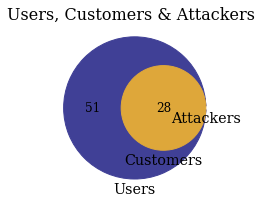

In [56]:
fig = plt.figure(figsize=(4,3))
fig.suptitle('Users, Customers & Attackers', fontsize=16)

ax = plt.subplot2grid((1,1), (0,0))

venn=venn3(ax=ax,subsets = {'001':len(attackers_set)-len(intersec_customers_attacker)-len(intersec_users_attackers)+len(intersec_users_customers_attackers), 
                            '010':len(customers_set)-len(intersec_users_customers)-len(intersec_customers_attacker)+len(intersec_users_customers_attackers), 
                            '011':len(intersec_customers_attacker)-len(intersec_users_customers_attackers),
                            '100':len(users_set)-len(intersec_users_customers)-len(intersec_users_attackers)+len(intersec_users_customers_attackers),
                            '101':len(intersec_users_attackers)-len(intersec_users_customers_attackers),
                            '110':len(intersec_users_customers)-len(intersec_users_customers_attackers),
                            '111':len(intersec_users_customers_attackers)},\
          set_labels = ('Users', 'Customers','Attackers'),\
          alpha=1)
try:
    venn.get_patch_by_id('100').set_color('#404096')
except:
    print("*Users set is empty!")  
    
try:
    venn.get_patch_by_id('110').set_color('#DEA73A')
except:
    print("*Customers set is empty!")   

try:
    venn.get_patch_by_id('001').set_color('#D92120')
except:
    print("*Attackers set is empty!")

fig.show()
fig.savefig('graphs/user_customers_attackers.eps', format='eps', dpi=1200) 

## 5.2. Distribution of login times per user

In [57]:
num_distinct_logins_per_user=df_logins['userid'].value_counts()
freq_distinct_logins_per_user=num_distinct_logins_per_user.value_counts()
cum_dist_user_logins = np.linspace(0.,1.,len(num_distinct_logins_per_user))
cdf_user_logins = pd.Series(cum_dist_user_logins, index=num_distinct_logins_per_user.sort_values())

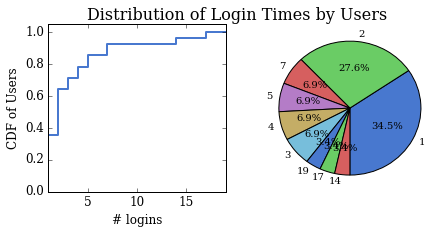

In [58]:
if len(num_distinct_logins_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Login Times by Users', fontsize=16)

    #Plot CDF
    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_logins.plot(ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("# logins")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_logins_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.3. Distribution of IP addresses per user

In [59]:
num_distinct_ips_per_user=df_logins.groupby(['userid','userip']).size().reset_index()['userid'].value_counts()
freq_distinct_ips_per_user=num_distinct_ips_per_user.value_counts()
cum_dist_user_ips = np.linspace(0.,1.,len(num_distinct_ips_per_user))
cdf_user_ips = pd.Series(cum_dist_user_ips, index=num_distinct_ips_per_user.sort_values())

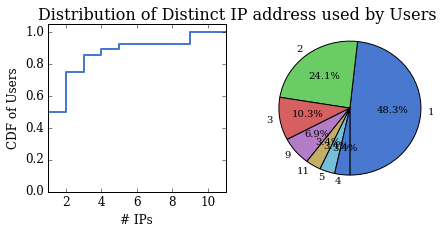

In [60]:
if len(num_distinct_ips_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Distinct IP address used by Users', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_ips.plot( ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("# IPs")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_ips_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.4. Distribution of Number of Payments by Users

In [61]:
num_distinct_payments_per_user=df_payments['userid'].value_counts()
freq_distinct_payments_per_user=num_distinct_payments_per_user.value_counts()
cum_dist_user_payments = np.linspace(0.,1.,len(num_distinct_payments_per_user))
cdf_user_payments = pd.Series(cum_dist_user_payments, index=num_distinct_payments_per_user.sort_values())

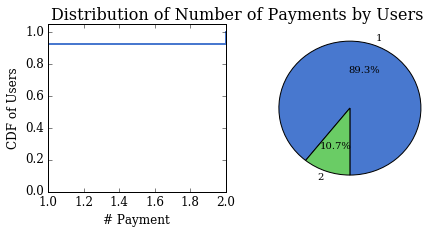

In [62]:
if len(num_distinct_payments_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Number of Payments by Users', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_payments.plot( ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("# Payment")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_payments_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.5. Total amount of money earned

In [63]:
total_earned=df_payments['amountpaid'].values.sum()
'US$ {:,.2f}'.format(float(total_earned))

'US$ 307.00'

## 5.6. Distribution of the money paid by Users

In [64]:
num_distinct_payments_money_per_user=df_payments['amountpaid'].value_counts()
freq_distinct_payments_money_per_user=num_distinct_payments_money_per_user.value_counts()
cum_dist_user_payments_money = np.linspace(0.,1.,len(num_distinct_payments_money_per_user))
cdf_user_payments_money = pd.Series(cum_dist_user_payments_money, index=num_distinct_payments_money_per_user.sort_values())

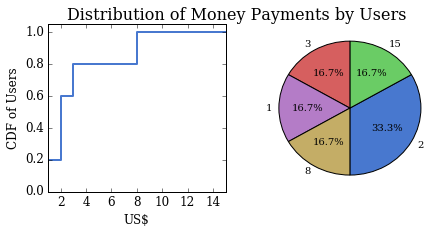

In [65]:
if len(num_distinct_payments_money_per_user)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Distribution of Money Payments by Users', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    ax1 = cdf_user_payments_money.plot( ax=ax1,lw=2, drawstyle='steps',legend=False)
    ax1.set_xlabel("US$")
    ax1.set_ylabel("CDF of Users")
    ax1.set_ylim(0,1.05)

    ax2 = plt.subplot2grid((1,2), (0,1))
    freq_distinct_payments_money_per_user.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")
# fig.savefig('../figs/cdf_users_attacks.eps', bbox_inches='tight',format='eps', dpi=1200)

## 5.7. Distribution of Countries that users access Booters

In [66]:
logins_country_distribution=df_logins_iptoasn['country'].value_counts()

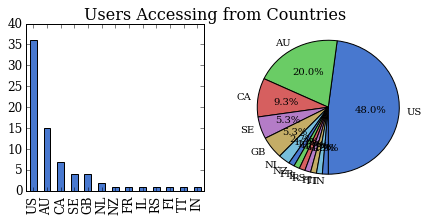

In [67]:
if len(logins_country_distribution)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Users Accessing from Countries', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    logins_country_distribution.plot(ax=ax1,kind='bar')
    ax1.set_ylabel("")

    ax2 = plt.subplot2grid((1,2), (0,1))
    logins_country_distribution.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")

## 5.8. Countries of blacklisted IPs

In [68]:
blacklist_country_distribution=df_blacklist_iptoasn['country'].value_counts()

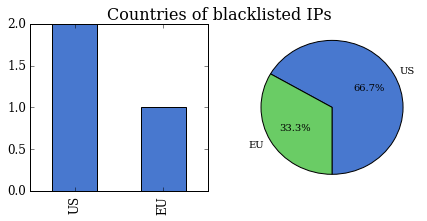

In [69]:
if len(blacklist_country_distribution)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Countries of blacklisted IPs', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    blacklist_country_distribution.plot(ax=ax1,kind='bar')
    ax1.set_ylabel("")

    ax2 = plt.subplot2grid((1,2), (0,1))
    blacklist_country_distribution.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")

## 5.9. Countries of target IPs

In [70]:
attacks_country_distribution=df_attacks_iptoasn['country'].value_counts()

In [71]:
if len(attacks_country_distribution)>0:
    fig = plt.figure()
    fig = plt.figure(figsize=(7, 3))
    fig.suptitle('Countries of target IPs', fontsize=16)

    ax1 = plt.subplot2grid((1,2), (0,0))
    attacks_country_distribution.plot(ax=ax1,kind='bar')
    ax1.set_ylabel("")

    ax2 = plt.subplot2grid((1,2), (0,1))
    attacks_country_distribution.plot(ax=ax2,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10)
    ax2.set_ylabel("")

    fig.show()
else:
    print("Unfortunately, there is no data available!")

Unfortunately, there is no data available!


<h2 align="center">!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!<br>
FIFTH PART: Query Interface<br>
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!</h2> 

In [72]:
from ipywidgets import widgets, interact
from IPython.display import display,clear_output

##  5.1. Search user by name or email

In [73]:
def searchfor_username_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_username.value,"\" in df_users:")
    display(df_users[df_users['username']== searchfor_username.value.lower()])

def searchfor_useremail_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_useremail.value,"\" in df_users:")
    display(df_users[df_users['useremail']== searchfor_useremail.value])
    print("Searching for \"",searchfor_useremail.value,"\" in df_payment:")
    display(df_payments[df_payments['paymentemail']== searchfor_useremail.value])

In [74]:
searchfor_username = widgets.Text(description="username")
display(searchfor_username)
searchfor_username.on_submit(searchfor_username_submit)

searchfor_useremail = widgets.Text(description="email")
display(searchfor_useremail)
searchfor_useremail.on_submit(searchfor_useremail_submit)

## 5.2. Search attacks by username or userid

In [75]:
def searchfor_attacks_userid_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_attacks_userid.value,"\" in df_attacks:")
    display(df_attacks[df_attacks['userid']== searchfor_attacks_userid.value])

def searchfor_attacks_username_submit(sender):
    clear_output()
    print("Searching for \"",searchfor_attacks_username.value,"\" in df_attacks:")
    userid=df_users[df_users['username']==searchfor_attacks_username.value.lower()]['userid'].iloc[0]
    display(df_attacks[df_attacks['userid']== userid])

In [76]:
searchfor_attacks_username = widgets.Text(description="username",)
display(searchfor_attacks_username)
searchfor_attacks_username.on_submit(searchfor_attacks_username_submit)

searchfor_attacks_userid = widgets.Text(description="userid")
display(searchfor_attacks_userid)
searchfor_attacks_userid.on_submit(searchfor_attacks_userid_submit)

## 5.3. Search IP address by userid or username

In [77]:
def search_ips_by_userid_submit(sender):
    clear_output()
    print("Searching for \"",search_ips_by_userid.value,"\" in df_logins:")
    display(df_logins[df_logins['userid']== int(search_ips_by_userid.value)])

def search_ips_by_username_submit(sender):
    clear_output()
    print("Searching for \"",search_ips_by_username.value,"\" in df_logins:")
    userid=df_users[df_users['username']==search_ips_by_username.value.lower()]['userid'].iloc[0]
    display(df_logins[df_logins['userid']== userid])

In [78]:
search_ips_by_username = widgets.Text(description="username")
display(search_ips_by_username)
search_ips_by_username.on_submit(search_ips_by_username_submit)

search_ips_by_userid = widgets.Text(description="userid")
display(search_ips_by_userid)
search_ips_by_userid.on_submit(search_ips_by_userid_submit)